# vim-emu evaluation for journal version of smoke testing paper

## Documentation to setup the experiments

### Branch
`son-emu` : `gh/paper2/evaluation`

### Error 'too many open files' during large experiments

Solution is to increase the `ulimit -n` (maximum number of open files) on the machine. Unfortunately, was not able to do this for a normal user on a Ubuntu 16.04. Only for the `root` user.

```sh
# switch to root
sudo su

# change sys. limit
vim /etc/sysctl.conf 
# add
fs.file-max = 2097152
# change limit for root user
ulimit -Sn 500000
ulimit -Hn 500000
# check
ulimit -a
# run your experiment using root
```


In [1]:
# global settings
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.interpolate import griddata
import numpy as np
import seaborn as sns
import pandas as pd
import itertools
import matplotlib.ticker as ticker

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
sns.set_style("ticks")
sns.set_context({"figure.figsize": (10, 5)})


## PoP scaleability

Start emulator platform with diffrent number of PoPs for `line`, `star`, `rdm05`, and `rdm15` topology.

Experiment execution:

* `TODO`

In [3]:
# read results
df1 = pd.read_pickle("data/2018-08-07-tango1-scaling_experiment_log.pkl")
df2 = pd.read_pickle("data/2018-08-12-tango1-scaling_experiment_log_random.pkl")
df = pd.concat([df1, df2], sort=False)
# some renaming
df["topology"] = df["topology"].str.replace("G", "rdm")
#df = df[df["n_pops"] < 1000]
#print(df["topology"])
df_line = df[df["topology"] == "line"]
df_star = df[df["topology"] == "star"]
df_rdm05 = df[df["topology"] == "rdm(k=0.5)"]
df_rdm15 = df[df["topology"] == "rdm(k=1.5)"]

# get some statistics to print
df_single = df_line[df_line["n_pops"]== 1]
df_single = df_single.groupby("n_pops").mean()
print("AVG set up time for 1 PoP:")
print(df_single["time_total"])
print("---")
print("Mean setup times per topology w. 128 PoPs:")
print(df[df["n_pops"]==128].groupby("topology").mean()["time_total"])
print("---")
print("Mean setup times per topology w. 1024 PoPs:")
print(df[df["n_pops"]==1024].groupby("topology").mean()["time_total"])

AVG set up time for 1 PoP:
n_pops
1    3.812558
Name: time_total, dtype: float64
---
Mean setup times per topology w. 128 PoPs:
topology
line          103.267464
rdm(k=0.5)     91.775690
rdm(k=1.5)    197.732408
star          105.819495
Name: time_total, dtype: float64
---
Mean setup times per topology w. 1024 PoPs:
topology
line           5044.232522
rdm(k=0.5)     3703.972774
rdm(k=1.5)    10272.835899
star           5518.691321
Name: time_total, dtype: float64


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


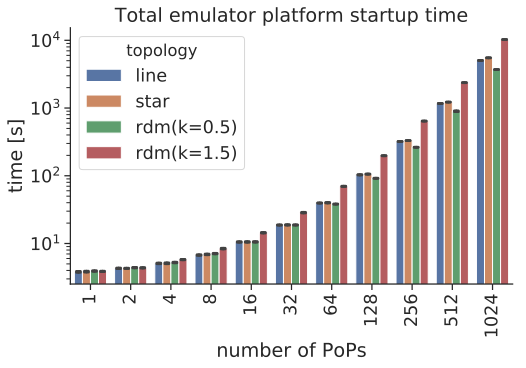

In [4]:
sns.set(font_scale=1.6)
sns.set_style("ticks")
#sns.set_palette("Blues", n_colors=3) # Greys, Blues_d
dff = df[df["topology"] != "mesh"].copy()
ax = sns.catplot(x='n_pops',
                    y='time_total',
                    hue='topology',
                    data=dff,
                    kind="bar",
                    legend_out=False,
                    height=5.5,
                    aspect=1.4,
                    capsize=.1)
ax.set_xlabels("number of PoPs")
ax.set_xticklabels(rotation=90)
ax.set_ylabels("time [s]")
ax.fig.get_axes()[0].set_yscale('log', nonposy='clip')
plt.title("Total emulator platform startup time")
plt.tight_layout()
ax.savefig("plots/sdk_emu_startup_compare_line_star_rdm.png", dpi=300)
ax.savefig("plots/sdk_emu_startup_compare_line_star_rdm.pdf", dpi=300)

## PoP scaleability: Memory consumption

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


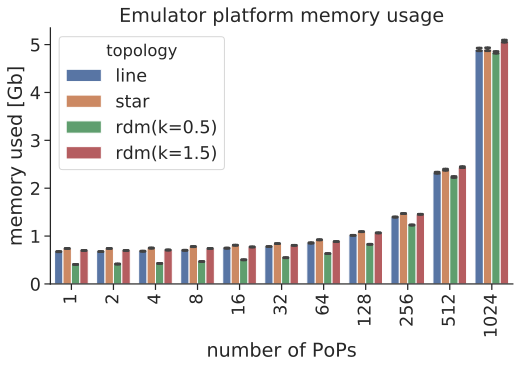

In [5]:
sns.set(font_scale=1.6)
sns.set_style("ticks")
#sns.set_palette("Blues", n_colors=3) # Greys, Blues_d
dff = df[df["topology"] != "mesh"].copy()
dff["mem_used"] = dff["mem_used"].map(lambda x: x / (1024 * 1024 * 1024))
#min_mem = dff["mem_used"].min() - 0.1
#dff["mem_used"] -= min_mem
ax = sns.catplot(x='n_pops',
                    y='mem_used',
                    hue='topology',
                    data=dff,
                    kind="bar",
                    legend_out=False,
                    height=5.5,
                    aspect=1.4,
                    capsize=.1)
ax.set_xlabels("number of PoPs")
ax.set_ylabels("memory used [Gb]")
#ax.fig.get_axes()[0].set_yscale('log', nonposy='clip')
ax.set_xticklabels(rotation=90)
#ax.set(ylim=(0, 6.0))
plt.title("Emulator platform memory usage")
plt.tight_layout()
ax.savefig("plots/sdk_emu_mem_compare_line_star_rdm.png", dpi=300)
ax.savefig("plots/sdk_emu_mem_compare_line_star_rdm.pdf", dpi=300)

## PoP scaleability: Setup time breakdown

/opt/conda/lib/python3.6/site-packages/matplotlib/legend.py:592: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f377f396da0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))
/opt/conda/lib/python3.6/site-packages/matplotlib/legend.py:592: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f377f28f6d8> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))
/opt/conda/lib/python3.6/site-packages/matplotlib/legend.py:592: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f377f1cef98> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))
/opt/conda/lib/python3.6/site-packages/matplotlib/legend.py:592: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f377f28f080> has a label of '_nolegend_' which cannot be automatically added to the legend.
  'legend.'.format(

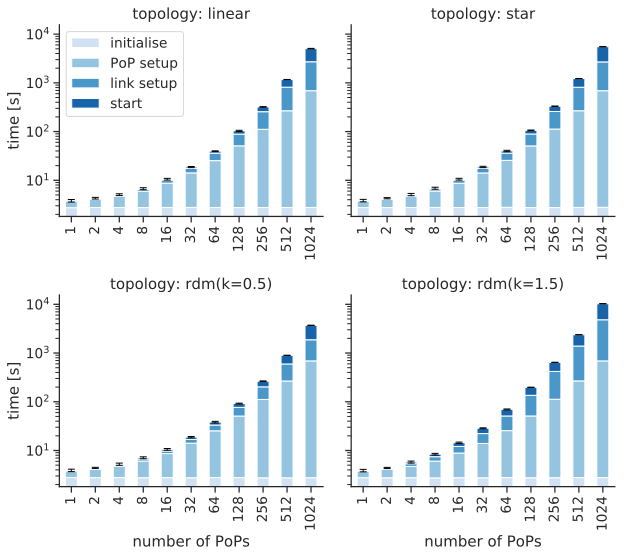

In [6]:
#df = pd.read_pickle("data/2017-12-05-scaling_experiment.pkl")
sns.set(font_scale=1.25)
sns.set_style("ticks", {'legend.frameon': True})
sns.set_palette("Blues", n_colors=4) # Greys, Blues_d

lbl_env_boot = "initialise"
lbl_pop_create = "PoP setup"
lbl_link_create = "link setup"
lbl_topo_start = "start"

dff = df.rename(columns={"time_env_boot": lbl_env_boot,
                        "time_pop_create": lbl_pop_create,
                        "time_link_create": lbl_link_create,
                        "time_topo_start": lbl_topo_start})
df_line = dff[dff["topology"] == "line"].groupby(["n_pops"]).mean()
std_line = dff[dff["topology"] == "line"].groupby(["n_pops"])["time_total"].std().reset_index()
df_line = df_line[[lbl_env_boot, lbl_pop_create, lbl_link_create, lbl_topo_start]]
df_star = dff[dff["topology"] == "star"].groupby(["n_pops"]).mean()
std_star = dff[dff["topology"] == "star"].groupby(["n_pops"])["time_total"].std().reset_index()
df_star = df_star[[lbl_env_boot, lbl_pop_create, lbl_link_create, lbl_topo_start]]
df_rdm05 = dff[dff["topology"] == "rdm(k=0.5)"].groupby(["n_pops"]).mean()
std_rdm05 = dff[dff["topology"] == "rdm(k=0.5)"].groupby(["n_pops"])["time_total"].std().reset_index()
df_rdm05 = df_rdm05[[lbl_env_boot, lbl_pop_create, lbl_link_create, lbl_topo_start]]
df_rdm15 = dff[dff["topology"] == "rdm(k=1.5)"].groupby(["n_pops"]).mean()
std_rdm15 = dff[dff["topology"] == "rdm(k=1.5)"].groupby(["n_pops"])["time_total"].std().reset_index()
df_rdm15 = df_rdm15[[lbl_env_boot, lbl_pop_create, lbl_link_create, lbl_topo_start]]

#ticklabels = [1]
#ticklabels += [i if (i % 10 == 0) else "" for i in range(5, 101, 5)]

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharey=True)
f.set_size_inches(9, 8)

# calculate totals for error bar plot overlay
sum_line = df_line[lbl_env_boot] + df_line[lbl_pop_create] + df_line[lbl_link_create] + df_line[lbl_topo_start]
sum_line = sum_line.reset_index()
sum_line = sum_line.drop("n_pops", axis=1)
sum_line = sum_line.rename(columns={0: "_nolegend_"})

sum_star = df_star[lbl_env_boot] + df_star[lbl_pop_create] + df_star[lbl_link_create] + df_star[lbl_topo_start]
sum_star = sum_star.reset_index()
sum_star = sum_star.drop("n_pops", axis=1)
sum_star = sum_star.rename(columns={0: "_nolegend_"})

sum_rdm05 = df_rdm05[lbl_env_boot] + df_rdm05[lbl_pop_create] + df_rdm05[lbl_link_create] + df_rdm05[lbl_topo_start]
sum_rdm05 = sum_rdm05.reset_index()
sum_rdm05 = sum_rdm05.drop("n_pops", axis=1)
sum_rdm05 = sum_rdm05.rename(columns={0: "_nolegend_"})

sum_rdm15 = df_rdm15[lbl_env_boot] + df_rdm15[lbl_pop_create] + df_rdm15[lbl_link_create] + df_rdm15[lbl_topo_start]
sum_rdm15 = sum_rdm15.reset_index()
sum_rdm15 = sum_rdm15.drop("n_pops", axis=1)
sum_rdm15 = sum_rdm15.rename(columns={0: "_nolegend_"})

df_line.plot(ax=ax1, kind="bar", stacked=True)
sum_line.plot(ax=ax1, yerr=list(std_line["time_total"]*2.0), linewidth=0.0, elinewidth=1.0, color="black", **{"capsize": 3.5, "capthick": 1.0})
df_star.plot.bar(ax=ax2, stacked=True)
sum_star.plot(ax=ax2, yerr=list(std_star["time_total"]*2.0), linewidth=0.0, elinewidth=1.0, color="black", **{"capsize": 3.5, "capthick": 1.0})
df_rdm05.plot.bar(ax=ax3, stacked=True)
sum_rdm05.plot(ax=ax3, yerr=list(std_star["time_total"]*2.0), linewidth=0.0, elinewidth=1.0, color="black", **{"capsize": 3.5, "capthick": 1.0})
df_rdm15.plot.bar(ax=ax4, stacked=True)
sum_rdm15.plot(ax=ax4, yerr=list(std_star["time_total"]*2.0), linewidth=0.0, elinewidth=1.0, color="black", **{"capsize": 3.5, "capthick": 1.0})

sns.despine(ax=ax1, top=True, right=True, left=False, bottom=False)
sns.despine(ax=ax2, top=True, right=True, left=False, bottom=False)
sns.despine(ax=ax3, top=True, right=True, left=False, bottom=False)
sns.despine(ax=ax4, top=True, right=True, left=False, bottom=False)

ax1.set_xlabel("")
ax2.set_xlabel("")
ax3.set_xlabel("number of PoPs")
ax4.set_xlabel("number of PoPs")

ax1.set_ylabel("time [s]")
ax3.set_ylabel("time [s]")

f.get_axes()[0].set_yscale('log', nonposy='clip')

ax1.legend().set_visible(True)
ax2.legend().set_visible(False)
ax3.legend().set_visible(False)
ax4.legend().set_visible(False)

#ax1.axes.xaxis.set_ticklabels(ticklabels)
#ax2.axes.xaxis.set_ticklabels(ticklabels)
#ax3.axes.xaxis.set_ticklabels(ticklabels)

ax1.set_title("topology: linear")
ax2.set_title("topology: star")
ax3.set_title("topology: rdm(k=0.5)")
ax4.set_title("topology: rdm(k=1.5)")

plt.setp(ax1.xaxis.get_majorticklabels(), rotation=90)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=90)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=90)
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=90)

f.tight_layout()
f.savefig("plots/sdk_emu_startup_breakdown.png", dpi=300)
f.savefig("plots/sdk_emu_startup_breakdown.pdf", dpi=300)

## PoP scaleability: Start time and memory (direct topo comparison)

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


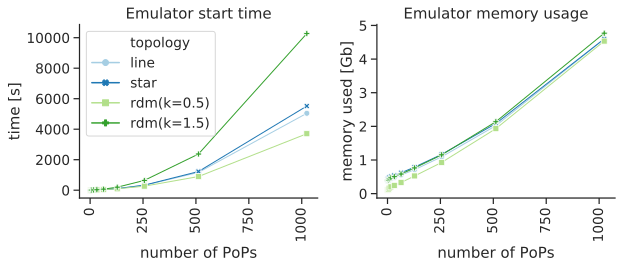

In [7]:
sns.set(font_scale=1.25)
sns.set_style("ticks", {'legend.frameon': True})

df1 = pd.read_pickle("data/2018-08-07-tango1-scaling_experiment_log.pkl")
df2 = pd.read_pickle("data/2018-08-12-tango1-scaling_experiment_log_random.pkl")
df = pd.concat([df1, df2], sort=False)
# some renaming
df["topology"] = df["topology"].str.replace("G", "rdm")
# change memory scale to GB
df["mem_used"] = df["mem_used"].map(lambda x: x / (1024 * 1024 * 1024))
min_mem = df["mem_used"].min() - 0.1
df["mem_used"] -= min_mem

f, (ax1, ax2) = plt.subplots(1, 2, sharey=False)
f.set_size_inches(9, 4)

#dff = df[df["topology"] != "mesh"].copy()

sns.lineplot(ax=ax1,
             x='n_pops',
             y='time_total',#y='mem_used',
             hue='topology',
             data=df,
             ci="sd",
             err_style="bars",
             style="topology",
             markers=True,
             dashes=False,
             lw=1.0,
             palette="Paired")

sns.lineplot(ax=ax2,
             x='n_pops',
             y='mem_used',
             hue='topology',
             data=df,
             ci=95,
             err_style="bars",
             style="topology",
             markers=True,
             dashes=False,
             lw=1.0,
             palette="Paired")

sns.despine(ax=ax1, top=True, right=True, left=False, bottom=False)
sns.despine(ax=ax2, top=True, right=True, left=False, bottom=False)

ax1.set_xlabel("number of PoPs")
ax2.set_xlabel("number of PoPs")

ax1.set_ylabel("time [s]")
ax2.set_ylabel("memory used [Gb]")

#f.get_axes()[0].set_xscale('log')
#f.get_axes()[0].set_yscale('log', nonposy='clip')
#f.get_axes()[1].set_xscale('log')
#f.get_axes()[1].set_yscale('log', nonposy='clip')

ax1.legend().set_visible(True)
ax2.legend().set_visible(False)

ax1.set_title("Emulator start time")
ax2.set_title("Emulator memory usage")


plt.setp(ax1.xaxis.get_majorticklabels(), rotation=90)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=90)

f.tight_layout()
f.savefig("plots/sdk_emu_startup_mem_compare.png", dpi=300)
f.savefig("plots/sdk_emu_startup_mem_compare.pdf", dpi=300)

## Service start times

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


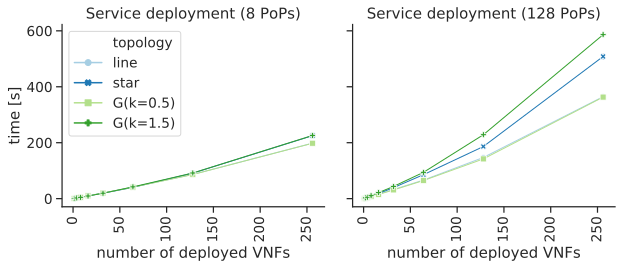

In [8]:
df1 = pd.read_pickle("data/2018-08-15-tango1-service_experiment_line_star.pkl")
df2 = pd.read_pickle("data/2018-08-16-tango1-service_experiment_rdm05_rdm15.pkl")
df = pd.concat([df1, df2], sort=False)
# TODO load second DF from experiments and concat them both to df

df_8pop = df[df["n_pops"]==8]
df_128pop = df[df["n_pops"]==128]

sns.set(font_scale=1.25)
sns.set_style("ticks", {'legend.frameon': True})

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_size_inches(9, 4)

#dff = df[df["topology"] != "mesh"].copy()

sns.lineplot(ax=ax1,
             x='service_size',
             y='time_service_start',
             hue='topology',
             data=df_8pop,
             ci="sd",
             err_style="bars",
             style="topology",
             markers=True,
             dashes=False,
             lw=1.0,
             palette="Paired")

sns.lineplot(ax=ax2,
             x='service_size',
             y='time_service_start',
             hue='topology',
             data=df_128pop,
             ci=95,
             err_style="bars",
             style="topology",
             markers=True,
             dashes=False,
             lw=1.0,
             palette="Paired")

sns.despine(ax=ax1, top=True, right=True, left=False, bottom=False)
sns.despine(ax=ax2, top=True, right=True, left=False, bottom=False)

ax1.set_xlabel("number of deployed VNFs")
ax2.set_xlabel("number of deployed VNFs")

ax1.set_ylabel("time [s]")
ax2.set_ylabel("time [s]")

#f.get_axes()[0].set_xscale('log')
#f.get_axes()[0].set_yscale('log', nonposy='clip')
#f.get_axes()[1].set_xscale('log')
#f.get_axes()[1].set_yscale('log', nonposy='clip')

ax1.legend().set_visible(True)
ax2.legend().set_visible(False)

ax1.set_title("Service deployment (8 PoPs)")
ax2.set_title("Service deployment (128 PoPs)")


plt.setp(ax1.xaxis.get_majorticklabels(), rotation=90)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=90)

f.tight_layout()
f.savefig("plots/sdk_emu_service_start_time3.png", dpi=300)
f.savefig("plots/sdk_emu_service_start_time3.pdf", dpi=300)

## OSM Case Study: VIM Setup Time Experiment

** Attention: OSM VIM list has a bug since the SO does not support to set a query limit. RO uses 100 per default. As a results, services can only be started on the first 100 PoPs **

Hardcoded limit: https://osm.etsi.org/gitweb/?p=osm/RO.git;a=blob;f=osm_ro/httpserver.py;h=0497bbacc9b4efd387ddcb896aef6fa591c1d6b3;hb=HEAD Line 277


### Double plot with normalized osm-create values

['config_id_x', 'mem_available_x', 'mem_free_x', 'mem_percent_x', 'mem_total_x', 'mem_used_x', 'n_links_x', 'n_pops_x', 'ns_running_x', 'service_size_x', 'osm vim-create', 'time_env_boot_x', 'time_link_create_x', 'time_pop_create_x', 'time_service_start_x', 'time_topo_start_x', 'time_total_x', 'time_total_on_board_x', 'time_total_vim_attach_x', 'vims_attached_x', 'config_id_y', 'mem_available_y', 'mem_free_y', 'mem_percent_y', 'mem_total_y', 'mem_used_y', 'n_links_y', 'n_pops_y', 'ns_running_y', 'r_id', 'service_size_y', 'time_action_y', 'emu. initialise', 'emu. link setup', 'emu. PoP setup', 'time_service_start_y', 'emu. start', 'time_total_y', 'time_total_on_board_y', 'time_total_vim_attach_y', 'vims_attached_y']


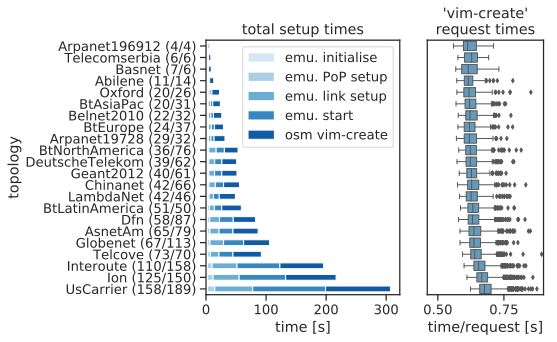

In [9]:
sns.set(font_scale=1.2)
sns.set_style("ticks")
sns.set_palette("Blues", n_colors=5) # Greys, Blues_d

# read results
df = pd.read_pickle("data/2018-08-21-tango1-osm31_zoo_experiment_setup.pkl")

#
data = df.to_dict('records')
for r in data:
    r["topology"] = "{} (${}$/${}$)".format(r["topology"], r["n_pops"], r["n_links"])
df = pd.DataFrame(data)

# sum up vim-create commands
df_vim = df[df["action"] == "vim-create"].groupby(["topology", "r_id"]).sum()
df_vim = df_vim.groupby(["topology"]).mean()

lbl_env_boot = "emu. initialise"
lbl_pop_create = "emu. PoP setup"
lbl_link_create = "emu. link setup"
lbl_topo_start = "emu. start"
lbl_vim_create = "osm vim-create"

dff = df.groupby(["topology"]).mean()
# combine summed dataframe and simple dataframe
dff = pd.merge(df_vim, dff, how='outer', left_index=True, right_index=True)
dff = dff.rename(columns={"time_env_boot_y": lbl_env_boot,
                        "time_pop_create_y": lbl_pop_create,
                        "time_link_create_y": lbl_link_create,
                        "time_topo_start_y": lbl_topo_start,
                         "time_action_x": lbl_vim_create})

print(list(dff))

# generate normalized osm vim-create values
df_vim2 = df.copy()
df_vim2 = df_vim2[df_vim2["action"] == "vim-create"]#.groupby(["topology", "r_id"]).mean()
#df_vim2["time_action"] /= df_vim2["n_pops"]

#df_vim2[df_vim2["action"] == "vim-create"].groupby(["topology", "r_id"]).mean()

#print(df_vim2)

# sort
dff = dff.sort_values(by=["n_pops_y"], ascending=False)
# select columns to show
dff = dff[[lbl_env_boot, lbl_pop_create, lbl_link_create, lbl_topo_start, lbl_vim_create]]

f, ax = plt.subplots(1, 2, sharey=False, gridspec_kw = {'width_ratios':[5, 3]})
f.set_size_inches(8, 5) # set width 7 for paper



for i in range(0, 2):
    #ax.set_yscale('log', nonposy='clip')
    #ax.set_xscale('log', nonposx='clip')
    if i == 0:
        dff.plot.barh(ax=ax[i], stacked=True)
        
        # fill with patterns for printing
        #bars = ax[i].patches
        #hatches = ["//", "\\", "**", "o", ".."] * 22
        #for b, h in zip(bars, hatches):
        #    b.set_hatch(h)
        
        ax[i].set_xlabel("time [s]")
        ax[i].set_ylabel("topology")
        ax[i].set_title("total setup times")
    else:  
        df_vim2 = df_vim2.sort_values(by=["n_pops"], ascending=True).copy()
        sns.boxplot(ax=ax[i], data=df_vim2, y="topology", x="time_action", orient="h", color="#569DCB", linewidth=1.0, fliersize=3.0)
        ax[i].set_title("'vim-create'\nrequest times")
        ax[i].set_xlabel("time/request [s]")
        ax[i].set_xlim(0.46, 0.90)
        ax[i].get_yaxis().set_visible(False)  # sharing Y axis does not work so we need to hide it!
f.tight_layout()
plt.savefig("plots/osm_emu_total_vim_create_time_all2.png", dpi=300)
plt.savefig("plots/osm_emu_total_vim_create_time_all2.pdf", dpi=300)

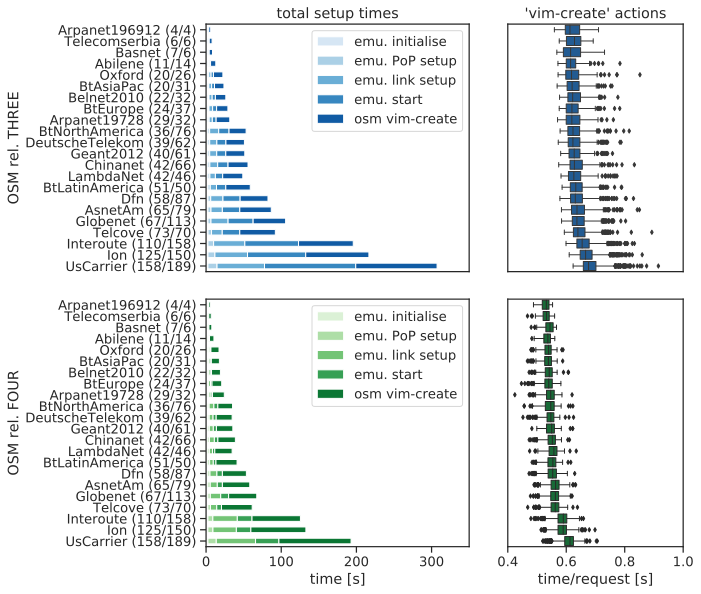

In [13]:
def rename_topos(df):
    data = df.to_dict('records')
    for r in data:
        r["topology"] = "{} (${}$/${}$)".format(r["topology"], r["n_pops"], r["n_links"])
    return pd.DataFrame(data)

def rename_columns(df):
    lbl_env_boot = "emu. initialise"
    lbl_pop_create = "emu. PoP setup"
    lbl_link_create = "emu. link setup"
    lbl_topo_start = "emu. start"
    lbl_vim_create = "osm vim-create"
    return df.rename(columns={"time_env_boot_y": lbl_env_boot,
                        "time_pop_create_y": lbl_pop_create,
                        "time_link_create_y": lbl_link_create,
                        "time_topo_start_y": lbl_topo_start,
                         "time_action_x": lbl_vim_create})
    

def calc_vim_create_sum(df):
    r = df[df["action"] == "vim-create"].groupby(["topology", "r_id"]).sum()
    return r.groupby(["topology"]).mean()


#
# Data
#

# load data
df1 = rename_topos(pd.read_pickle("data/2018-08-21-tango1-osm31_zoo_experiment_setup.pkl"))
df_vim_norm1 = df1.copy()
df2 = rename_topos(pd.read_pickle("data/2018-08-24-tango1-osm4_zoo_experiment_setup.pkl"))  # TODO chenge source
df_vim_norm2 = df2.copy()

# calculate sums
df_vim_sum1 = calc_vim_create_sum(df1)
df_vim_sum2 = calc_vim_create_sum(df2)

# group results
df1 = df1.groupby(["topology"]).mean()
df2 = df2.groupby(["topology"]).mean()

# combine summed dataframe and simple dataframe
df_merged1 = pd.merge(df_vim_sum1, df1, how='outer', left_index=True, right_index=True)
df_merged2 = pd.merge(df_vim_sum2, df2, how='outer', left_index=True, right_index=True)

# generate normalized osm vim-create values
df_vim_norm1 = df_vim_norm1[df_vim_norm1["action"] == "vim-create"]
df_vim_norm2 = df_vim_norm2[df_vim_norm2["action"] == "vim-create"]

# sort
df_merged1 = df_merged1.sort_values(by=["n_pops_y"], ascending=False)
df_vim_norm1 = df_vim_norm1.sort_values(by=["n_pops"], ascending=True).copy()
df_merged2 = df_merged2.sort_values(by=["n_pops_y"], ascending=False)
df_vim_norm2 = df_vim_norm2.sort_values(by=["n_pops"], ascending=True).copy()

# rename columns for plot
df_merged1 = rename_columns(df_merged1)
df_merged2 = rename_columns(df_merged2)

# select columns to show
df_merged1 = df_merged1[[lbl_env_boot, lbl_pop_create, lbl_link_create, lbl_topo_start, lbl_vim_create]]
df_merged2 = df_merged2[[lbl_env_boot, lbl_pop_create, lbl_link_create, lbl_topo_start, lbl_vim_create]]


#
# Plot
#
f, ax = plt.subplots(2, 2, sharey=False, sharex=False, gridspec_kw = {'width_ratios':[6, 4]})
f.set_size_inches(10, 8.5)
sns.set(font_scale=1.2)
sns.set_style("ticks", {'legend.frameon': True})

for r in range(0, 2):
    if r == 0:
        sns.set_palette("Blues", n_colors=5)
        bp_color= "#105BA4"
        name = "OSM rel. THREE"
        df_plot_A = df_merged1
        df_plot_B = df_vim_norm1
        ax[r][0].get_xaxis().set_visible(False)
        ax[r][1].get_xaxis().set_visible(False)
        ax[r][1].set_title("'vim-create' actions")
        ax[r][0].set_title("total setup times")
    else:
        sns.set_palette("Greens", n_colors=5)
        bp_color="#0B7734"
        name = "OSM rel. FOUR"
        df_plot_A = df_merged2
        df_plot_B = df_vim_norm2 

    # total time stacked bars
    df_plot_A.plot.barh(ax=ax[r][0], stacked=True)        
    ax[r][0].set_xlabel("time [s]")
    ax[r][0].set_ylabel("{}".format(name))
    ax[r][0].set_xlim(0, 350)
    # request times boxplot
    sns.boxplot(ax=ax[r][1], data=df_plot_B, y="topology", x="time_action", orient="h", color=bp_color, linewidth=1.0, fliersize=3.0)  
    ax[r][1].set_xlabel("time/request [s]")
    ax[r][1].set_xlim(0.4, 1.0)
    ax[r][1].get_yaxis().set_visible(False)  # sharing Y axis does not work so we need to hide it!
    
#for r in range(0, 2):
#    for c in range(0, 2):
#        sns.despine(ax=ax[r][c], top=True, right=True, left=False, bottom=False)

f.tight_layout()
plt.savefig("plots/osm_emu_total_vim_create_time_compare.png", dpi=300)
plt.savefig("plots/osm_emu_total_vim_create_time_compare.pdf", dpi=300)

In [ ]:
def plot_cdf(ax, d_in, col="time_action", *args, **kwargs):
    d_in = d_in.copy()
    samples = list(d_in[col].tolist())
    samples_sorted = np.sort(samples)
    yvals = np.arange(len(samples_sorted))/float(len(samples_sorted)) 
    ax.step(samples_sorted, yvals, *args, **kwargs)

def plot_cdf_binned(ax, d_in, bins=50, col="time_action", *args, **kwargs):
    d_in = d_in.copy()
    samples = list(d_in[col].tolist())
    counts, bins = np.histogram(samples, bins=bins)
    cdf = np.cumsum(counts)/np.sum(counts) 
    ax.plot(np.vstack((bins, np.roll(bins, -1))).T.flatten()[:-2],
            np.vstack((cdf, cdf)).T.flatten(),
            *args, **kwargs)

In [ ]:
df2 = pd.read_pickle("data/2018-08-21-tango1-osm31_zoo_experiment_setup.pkl")
df3 = df2[["action", "topology", "time_action"]]

topos = list(set(df3["topology"].values.tolist()))
topos = ['Abilene', 'DeutscheTelekom', 'UsCarrier']
actions = ["vim-create", "vim-show", "vim-delete"]
titles = ["'osm vim-create' response times", "'osm vim-show' response times", "'osm vim-delete' response times"]

f, axs = plt.subplots(1, 3, sharey=False)
f.set_size_inches(12, 6)

for i in range(0, 3):
    ax = axs[i]
    for t in topos:
        dff = df3[(df3["topology"] == t) & (df3["action"] == actions[i])]
        plot_cdf_binned(ax, dff, bins=150, label=t, lw=1.5)
    #ax.set_xlim(0.47, 0.57)
    ax.set_ylim(0, 1)
    ax.set_xlabel("time [s]")
    ax.set_ylabel("ECDF")
    ax.set_title(titles[i])
plt.legend()
plt.tight_layout()
plt.savefig("plots/osm_emu_cdf_vim_create_time.png", dpi=300)
plt.savefig("plots/osm_emu_cdf_vim_create_time.pdf", dpi=300)

## OSM Service Deployment

ping pong service on two different topologies

action==ns-create?
time_action?

it is in time_service_start
ns_running  

Check experiment code to get the deployment times of the services.
Scatter plot? X = n_services running, Y = total deployment time or deployment time of next service?


In [ ]:
sns.set(font_scale=1.2)
sns.set_style("ticks", {'legend.frameon': True})
sns.set_palette("Blues", n_colors=3) # Greys, Blues_d

RESULT_DIR = "2018-08-23-osm3_service_results"

def load_multi_df():
    paths = ["Abilene_r1.pkl",
            "Abilene_r2.pkl",
            "Abilene_r3.pkl",
            "Abilene_r4.pkl",
            "Abilene_r5.pkl",
            "DeutscheTelekom_r1.pkl",
            "DeutscheTelekom_r2.pkl",
            "DeutscheTelekom_r3.pkl",
            "DeutscheTelekom_r4.pkl",
            "DeutscheTelekom_r5.pkl",
            "UsCarrier_r1.pkl",
            "UsCarrier_r2.pkl",
            "UsCarrier_r3.pkl",
            "UsCarrier_r4.pkl",
            "UsCarrier_r5.pkl"]
    df = pd.concat([pd.read_pickle("data/{}/{}".format(RESULT_DIR, p)) for p in paths])
    return df

df = load_multi_df()

df1 = df[(df["action"] == "ns-create") & (df["topology"] == "Abilene")]
df2 = df[(df["action"] == "ns-create") & (df["topology"] == "DeutscheTelekom")]
df3 = df[(df["action"] == "ns-create") & (df["topology"] == "UsCarrier")]

#print(df3)
#print(df1[["action", "ns_running", "time_action"]])
palette = itertools.cycle(sns.color_palette())
f, ax = plt.subplots(1, 1, sharey=False)
f.set_size_inches(8, 2.4)
df1.plot.scatter(ax=ax, x="ns_running", y="time_action", label="Abilene", color=next(palette))
df2.plot.scatter(ax=ax, x="ns_running", y="time_action", label="DeutscheTelekom", color=next(palette))
df3.plot.scatter(ax=ax, x="ns_running", y="time_action", label="UsCarrier", color=next(palette))
ax.set_title("'ns-create' requests times")
ax.set_xlabel("running network services")
ax.set_ylabel("time [s]")
plt.tight_layout()
plt.savefig("plots/osm_emu_scatter_ns_create_time.png", dpi=300)
plt.savefig("plots/osm_emu_scatter_ns_create_time.pdf", dpi=300)

In [ ]:
sns.set(font_scale=1.2)
sns.set_style("ticks")
sns.set_palette("Blues", n_colors=3) # Greys, Blues_d
df = load_multi_df()
df = df[(df["action"] == "ns-create")]
df = df[(df["ns_running"].isin([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]))]

f, ax = plt.subplots(1, 1, sharey=False)
f.set_size_inches(10, 5)
ax = sns.boxplot(ax=ax, x="ns_running", y="time_action", hue="topology", data=df)

In [ ]:
sns.set(font_scale=1.2)
sns.set_style("ticks")
sns.set_palette("Blues", n_colors=3) # Greys, Blues_d

df1 = pd.read_pickle("data/2017-12-22-osm_zoo_service_abilene_64_osm_result.pkl")
df2 = pd.read_pickle("data/2017-12-22-osm_zoo_service_deutschetelekom_64_osm_result.pkl")

df = load_multi_df()

# add node and link numbers
#data = df.to_dict('records')
#for r in data:
#    r["topology"] = "{} (${}$/${}$)".format(r["topology"], r["n_pops"], r["n_links"])
#df = pd.DataFrame(data)

#print(df)
#print(df[["time_service_start"]])

dfc = df[df["action"] == "ns-create"]
dfd = df[df["action"] == "ns-delete"]

#print(dfd)

f, axs = plt.subplots(1, 2, sharey=True)
f.set_size_inches(8, 1.8)
sns.boxplot(ax=axs[0], data=dfc, y="topology", x="time_action", orient="h", linewidth=1.0, fliersize=3.0)
axs[0].set_title("'ns-create'")
axs[0].set_xlabel("time/request [s]")
axs[0].set_ylabel("")
axs[0].set_xlim(5, 25)
axs[0].get_yaxis().set_visible(True)  
sns.boxplot(ax=axs[1], data=dfd, y="topology", x="time_action", orient="h", linewidth=1.0, fliersize=3.0)
axs[1].set_title("'ns-delete'")
axs[1].set_xlabel("time/request [s]")
axs[1].set_ylabel("")
axs[1].set_xlim(0, 25)
axs[1].get_yaxis().set_visible(False)  
#f.subplots_adjust(bottom = 0)
#f.subplots_adjust(top = 1)
#f.subplots_adjust(right = 1)
#f.subplots_adjust(left = -1)
plt.tight_layout()
plt.savefig("plots/osm_emu_box_ns_create_delete_time.png", dpi=300)
plt.savefig("plots/osm_emu_box_ns_create_delete_time.pdf", dpi=300)